In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 10.0 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 17.8 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 30.9 MB/s eta 0:00:01
     |████████████████████████████████| 182 kB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 20.1 MB/s eta 0:00:01
     |████████████████████████████████| 12.0 MB 617 kB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047105 sha256=8c208f16e27e6cfb67792dd297f2e0495888918d31e85c298d07f832aa416d39
  Stored in directory: /private/var/folders/11/d8cxq2697096wvcz9x7ch7lr0000gn/T/pip-ephem-wheel-cache-hzxbarm6/wheels/b7/0d/f0/7ecae8427c515065d75410989e15e5785dd3975fe06e795cd9
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import spacy
from spacy import displacy

In [3]:
def extract_lines(filename):
    lines = []
    started = False
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line[0] == '<':
                started = True
                tmp = ''
            
            if started:
                tmp += line
                if line[len(line) - 2] == '>':
                    lines.append(tmp)
                    started = False
        
    return lines

In [4]:
def display_dependency_tree(doc):
    displacy.render(doc, style='dep')
#     json = doc.to_json()
#     for id in json['tokens']:
#         print(id)

In [13]:
def extract_noun_adj_pair(doc):
    
    # -- Set 1 --
    # Finds all with adjs with amod dependency to noun
    
    set1_pairs = []
    for token in doc:
        
        if token.dep_ == 'amod':
            noun = token.head.text
            
            # Check for compound nouns (e.g. air con)
            noun_children = token.head.children
            for noun_child in noun_children:
                if noun_child.dep_ == 'compound':
                    noun = noun_child.text + ' ' + noun
            
            # Check for conj
            tmp = token
            have_conj = True
            while have_conj:
                # Check for negation / advmod of adj (e.g. not comfortable, so easy)
                adj = tmp.text
                adj_prefix = ''
                for adj_child in tmp.children:
                    if adj_child.dep_ in ['neg', 'advmod']:
                        adj_prefix += adj_child.text + " "
                adj = adj_prefix + adj
                set1_pairs.append((noun.lower(), adj.lower()))
                
                have_conj = False
                for adj_child in tmp.children:
                    if adj_child.dep_ == 'conj':
                        have_conj = True
                        tmp = adj_child
    
    # -- Set 2 --
    # Finds all with child noun having nsubj dependency, and child adj having acomp dependency
    
    set2_pairs = []
    for token in doc:
        nouns = []
        adjs = []
        neg = ''
        
        for child in token.children:
            # Noun with nsubj dependency
            if child.dep_ == 'nsubj':
                noun = child.text
                # Check for conj
                tmp = child
                have_conj = True
                while have_conj:
                    nouns.append(tmp.text)

                    have_conj = False
                    for noun_child in tmp.children:
                        if noun_child.dep_ == 'conj':
                            have_conj = True
                            tmp = noun_child
                
            # Adj with acomp dependency
            if child.dep_ == 'acomp':
                # Check for conj
                tmp = child
                have_conj = True
                while have_conj:
                    # Check for negation / advmod of adj (e.g. not comfortable, so easy)
                    adj = tmp.text
                    adj_prefix = ''
                    for adj_child in tmp.children:
                        if adj_child.dep_ in ['neg', 'advmod']:
                            adj_prefix += adj_child.text + " "
                    adjs.append(adj_prefix + adj)

                    have_conj = False
                    for adj_child in tmp.children:
                        if adj_child.dep_ == 'conj':
                            have_conj = True
                            tmp = adj_child
            
            if child.dep_ == 'neg':
                neg = child.text + ' '
            
        if len(nouns)>0 and len(adjs)>0:
            for n in nouns:
                for a in adjs:
                    set2_pairs.append((n.lower(), (neg + a).lower()))

    # -- Set 3 --
    # Finds all adj with child noun having nsubj dependency
    
    set3_pairs = []
    for token in doc:
        if token.pos_ == 'ADJ':
            noun = None
            
            for child in token.children:
                if child.dep_ == 'nsubj':
                    noun = child.text
            
            if noun:
                # Check for conj
                tmp = token
                have_conj = True
                while have_conj:
                    # Check for negation / advmod of adj (e.g. not comfortable, so easy)
                    adj = tmp.text
                    adj_prefix = ''
                    for adj_child in tmp.children:
                        if adj_child.dep_ in ['neg', 'advmod']:
                            adj_prefix += adj_child.text + " "
                    adj = adj_prefix + adj
                    set3_pairs.append((noun.lower(), adj.lower()))

                    have_conj = False
                    for adj_child in tmp.children:
                        if adj_child.dep_ == 'conj':
                            have_conj = True
                            tmp = adj_child
                    
    return set3_pairs #set1_pairs + set2_pairs + set3_pairs

In [14]:
counts = defaultdict(lambda : 0)
nlp = spacy.load('en_core_web_sm')
lines = extract_lines('Reviews.txt')
for i, line in enumerate(lines):
    doc = nlp(line[1:-2])
    display_dependency_tree(doc)
    print(f'----- Review {i+1} -----')
    print(doc)
    for pair in extract_noun_adj_pair(doc):
        print(pair)
        counts[pair] += 1
    print()

----- Review 1 -----
1. Close to the city
2. Room is comfortable and clean
3. Good hospitality



----- Review 2 -----
Room very spacious, clean and comfortable. Smooth check in time. Helpful staff.



----- Review 3 -----
Nearer to all the shops and jonker walk.. convenient..
The room is spacious and clean
Good Hospitality



----- Review 4 -----
The bed is comfortable and the room was calm.



----- Review 5 -----
the location is so strategic and got parking lot to guest! and the room also so clean and really comfortable to stay
('room', 'also so clean')
('room', 'really comfortable')



----- Review 6 -----
Hotel is new and clean. Secure and plentiful parking. Shampoo, toothbrushes, shower cap n slippers are all available. All my expectations are met. Highly recommended



----- Review 7 -----
I like the staff, the service so nice. The housekeeping topped up our used toiletries, and also the parking also nice.
('parking', 'also also nice')



----- Review 8 -----
The room is well clean and comfortable



----- Review 9 -----
Because of faulty air-con, the staff arranged for a new room swiftly.



----- Review 10 -----
Great location, Nice staff and Great place to stay.



----- Review 11 -----
Location was good.
But no breakfast...



----- Review 12 -----
stay okay without breakfast package, but parking full on the peak season



----- Review 13 -----
television not more channels..room you must pay more because want room with windows



----- Review 14 -----
Iron that provided at the corner of each level
Spacious room
Many parking slots provided
New hotel
The bedsheets was not properly washed. I feel itchy and it annoyed me to sleep well.



----- Review 15 -----
Check in and check out really fast.. I like the way the staff handling customers..



----- Review 16 -----
Room is clean with new cabinet
Short of parking space



----- Review 17 -----
The room and cleanliness is excellent
The receptionist was answering calls and doing some paper work when i was in front of the reception, it take s about 15mins before she entertained me, there are more people queueing after me too.
I checked in ard 6pm, but she told me the room is not ready yet. What? I have to wait another 30mins. The service is bad, and she charged me the same amount even they delay my check in.
Need improvement in this area



----- Review 18 -----
i love the water pressure in the shower.
Additional charge of RM40 for early check-in.
Staffs are not well trained.
My booking did not come with breakfast.



----- Review 19 -----
The facilities could've been better, but overall enjoyable trip.



----- Review 20 -----
i arrived at about 3.00 pm but the room still not ready. need to wait 1/2 hour. The check in staff also need to improve. Maybe too old.Ask same question repeatedly.
('room', 'still not ready')



----- Review 21 -----
the service was so poor..yesterday night my brother want borrow the mop because his son broke the cup but the staff told him that the mop at store and the store was lock..room not clean properly
('room', 'not properly clean')



----- Review 22 -----
Everything. The room is dirty. Not worth every penny! The indian receptionist is very unfriendly. The food also not nice.
('food', 'not nice')



----- Review 23 -----
Not up to expectation honestly .
Rooms without window had a terrible smell .



----- Review 24 -----
Toilet door cannot lock.
Air conditioning very noisy.
Sound proof is poor. Can hear noises from other room.
Bed and pillow is clean but got some smell.



----- Review 25 -----
The staff was very rude, and the room was dirty.



----- Review 26 -----
The room was noisy with children in other rooms loud adults in next room would not shut up ask reception 4 times for them to keep the noise down
No breakfast and no fidge to buy your own. bathroom floor soaked with water as no lip on shower recess and toilet covered in water all in all an awful experience



----- Review 27 -----
Toilet was miserable. Not very functional



----- Review 28 -----
Service is not so good.



----- Review 29 -----
The bathroom too small to hang our clothes. No extra pillow provided.



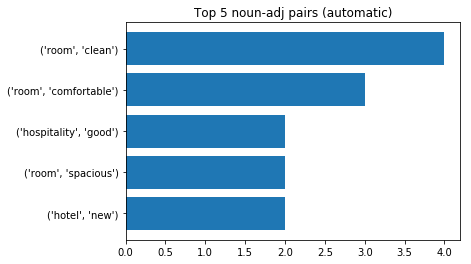

In [11]:
x = []
count = []
for k,v in sorted(counts.items(), key=lambda item: item[1], reverse=True)[:5]:
    x.append(str(k))
    count.append(v)

fig, ax = plt.subplots()
ax.set_title('Top 5 noun-adj pairs (automatic)')
ax.barh(x, count)
ax.invert_yaxis()  # labels read top-to-bottom

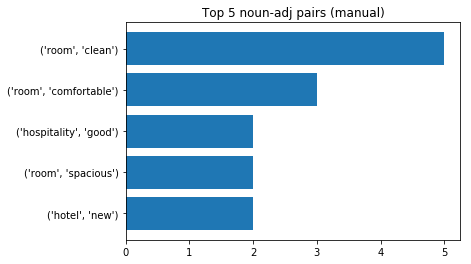

In [12]:
filename = 'Pairs.txt'
manual_counts = defaultdict(lambda : 0)
manual_hist = []
with open(filename, 'r') as f:
    for line in f.readlines():
        if line[0] == '<':
            pair = tuple(line[1:-2].split(' - '))
            manual_counts[pair] += 1
            manual_hist.append(str(pair))
            
x = []
count = []
for k,v in sorted(manual_counts.items(), key=lambda item: item[1], reverse=True)[:5]:
    x.append(str(k))
    count.append(v)

fig, ax = plt.subplots()
ax.set_title('Top 5 noun-adj pairs (manual)')
ax.barh(x, count)
ax.invert_yaxis()  # labels read top-to-bottom